# SLU18 - Hyperparameter Tuning : Learning notebook

### New concepts in this unit

*  Hyperparameter definition
*  Hyperparameter search
*  Model selection

### New tools in this unit
- [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
- [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

In [1]:
from IPython.display import Image
import warnings
warnings.simplefilter("ignore")
import pandas as pd

### Hyperparameter Definition

What are hyperparameters? Up until now we have mostly trained estimators (our machine learning models) like this:

In [2]:
from sklearn import tree
classifier = tree.DecisionTreeClassifier( ) 

What this means is we are creating a Decision Tree for a classification problem **using its default settings**. However, every single kind of model we use can be *tweaked* and modified to better adapt to our specific problem. For example, we can specify that we want a decision tree with a maximum depth of 5,

In [3]:
classifier = tree.DecisionTreeClassifier(max_depth=5) 

The knobs and parameters we can specify when creating a model are called **hyperparameters**. Part of a Data Scientist's job is to figure out the right set of hyperparameters that make our model perform better.

**You can ask: why can't we include the hyperparameters as a subset of the parameters of the classification problem to be learned?**

Doing that, you're mixing the rules of the learning process (the settings) with the learning process itself. That means the optimization process will drop rules that block it from minimizing errors instead of solving the problem that was stated, with the right rules and you end up with a bad solution. 

For instance, you will end up with a huge decision tree that is for sure not the best model in the real world (`max_depth` will explode to minimize training errors and you'll have a huge overfit problem). So we have to tune these hyperparameters by comparing performance of several similar models each of them with different settings. We use what is called a validation process for that.

### Loading the data

In this unit we will use the [Wisconsin Breast Cancer Dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic). It's a dataset containing measurements done on microscopic images of tissue cells from people with and without breast cancer. The dataset can thus be used to try to predict whether a patient has breast cancer or not.

The images look like the ones below,

![](https://i.imgur.com/ElLUPsZ.jpg)

In [4]:
from sklearn.datasets import load_breast_cancer
cancer_data = load_breast_cancer()

cancer = pd.DataFrame(cancer_data["data"],
                      columns=cancer_data["feature_names"])

cancer["malign"] = cancer_data.target
cancer["malign"] = cancer["malign"].replace({0:1, 1:0})

In [5]:
cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,malign
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


In [6]:
target_variable = "malign"
independent_variables = cancer.drop(target_variable, axis=1).columns

In [7]:
# Train-test split our dataset
from sklearn.model_selection import train_test_split
# To give us some performance information
from sklearn.metrics import classification_report

We keep a portion of the dataset for validation of the final model.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
                                        cancer[independent_variables],
                                        cancer[target_variable], 
                                        test_size=0.2,
                                        random_state=42
                                        )

When dealing with continuous hyperparameters, you should use continuous distributions as well.

In [9]:
from scipy.stats import uniform

uniform(1, 100)

### Hyperparameters search

So we have said that finding the right set of hyperparameters is part of the job of building a good estimator. However, there are tons of different hyperparameters we can set when training a model. 

In a jupyter notebook, we can use `?` at the end of a defined class/function to see its documentation.

For example, if we want to check the options for a `DecisionTreeClassifier`, we can do so like this:

In [10]:
tree.DecisionTreeClassifier?

So we have a lot of hyperparameters to choose! How can we do so without going crazy?. Well, fortunately we can search them automatically! Scikit-learn provides 2 different kinds of hyperparameter search strategies:

### Grid Search

When we perform a grid search, we basically define a list of possible values for our hyperparameters, and we test all of their possible combinations, given a reasonable search space for hyperparameters. We test them by training the estimator with those hyperparameters and evaluating its performance by doing cross validation.

So for example, if we have 2 hyperparameters that we want to search, a grid search would look as follows (every blue dot would be an experiment).


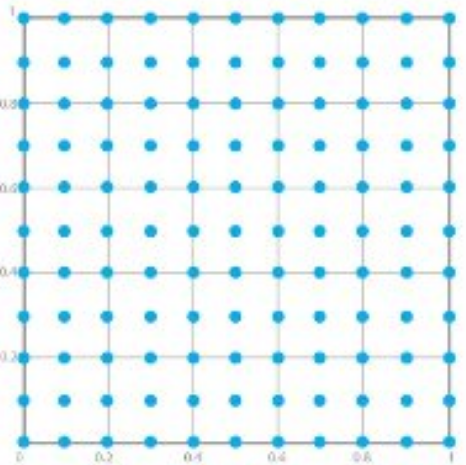

In [11]:
Image("media/grid_search.png")

In order to do a search, we need to define a hyperparameter space, that is, all the hyperparameters we want to test and their possible values. Be aware that each hyperparameter is of a different type, so checking the model's documentation is a good idea.

In [12]:
grid_search_parameter_space = {'max_depth': range(1, 10),
                   'max_features': range(1, len(independent_variables))
                  }

We also need to define the model that we are going to use. In this case we will use a simple DecisionTreeClassifier.

In [13]:
estimator = tree.DecisionTreeClassifier()

In [14]:
# Import the GridSearchCV class from sklearn
from sklearn.model_selection import GridSearchCV
# Check GridSearchCV usage
GridSearchCV?

Now we can define the grid search with cross validation. We need to specify the metric we want to use to guide the process. In this case we choose the AUC score. We can also specify how many CV partitions we want to use to evaluate each hyperparameters combination.

In [15]:
grid_search = GridSearchCV(
                estimator,
                grid_search_parameter_space,
                cv=5,
                scoring="roc_auc",
                return_train_score=True
                )

**NOTE: The %%timeit magic**

In the real world, when doing any kind of data intensive task, such as running a hyperparameter search, or training a model, processing time matters. That is the time it actually takes for the computer(s) to perform the task.

When using jupyter notebook, we can use the cell magic `%%timeit` to check how long a cell takes to run. %%timeit takes two main arguments, **n** (the number of loops to run) and **r** (the number of repetitions per loop). Usually you want to run a cell as many times as it is reasonable (if you don't specify *n*  or *r*, jupyter will figure out how many times to run it), to get a fair estimate of how long the cell takes to run. Think of it as cross validation for computing time!

In [16]:
%%timeit -n 1 -r 1

grid_search.fit(X_train, y_train)

10.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


We see it takes about 5 seconds to run the grid search.

We can access the best estimator found by the search with the `best_estimator_` param.

In [17]:
grid_search.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=14, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

You can grab the model parameters using `get_params` method like this

In [18]:
grid_search.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': 14,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

We can use the fitted grid search to predict using the estimator with the best found parameters

In [19]:
grid_search.predict(X_test)[:10]

array([0, 1, 1, 0, 0, 1, 1, 0, 1, 0])

We can also see the parameters for the best performing model.

In [20]:
grid_search.best_params_

{'max_depth': 2, 'max_features': 14}

And the best model's score.

In [21]:
grid_search.best_score_

0.9564234207129477

If we want to dig deeper into the search result, we can access the results obtained on each hyperparameter search iteration with `cv_results`.

In [22]:
pd.DataFrame(grid_search.cv_results_).sort_values(by="rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
42,0.002998,0.000341,0.001907,0.000225,2,14,"{'max_depth': 2, 'max_features': 14}",0.989289,0.898349,0.982456,...,0.956423,0.032064,1,0.971265,0.977632,0.961831,0.975853,0.958451,0.969006,0.007607
91,0.002449,0.000077,0.001837,0.000165,4,5,"{'max_depth': 4, 'max_features': 5}",0.964472,0.969298,0.972652,...,0.946610,0.028239,2,0.983150,0.995924,0.986511,0.991105,0.989633,0.989265,0.004309
49,0.003313,0.000077,0.001790,0.000049,2,21,"{'max_depth': 2, 'max_features': 21}",0.952194,0.905057,0.988132,...,0.945186,0.028717,3,0.957575,0.967508,0.965357,0.970354,0.964548,0.965068,0.004252
99,0.003270,0.000160,0.001743,0.000023,4,13,"{'max_depth': 4, 'max_features': 13}",0.986155,0.937564,0.980908,...,0.944290,0.038663,4,0.983408,0.999434,0.989633,0.989762,0.985832,0.989614,0.005464
38,0.002515,0.000077,0.001756,0.000046,2,10,"{'max_depth': 2, 'max_features': 10}",0.940700,0.930599,0.980134,...,0.943971,0.023934,5,0.960220,0.970904,0.962251,0.963481,0.950412,0.961454,0.006595


### Randomized Search

Unlike the Grid Search, Randomized Search works by randomly selecting combinations of hyperparameters. This method tends to perform better than the Grid Search when the hyperparameters space is big (and thus impractical to "brute force" the optimal solution via a Grid search).

If we had 2 hyperparameters, a Randomized Search would look like this:

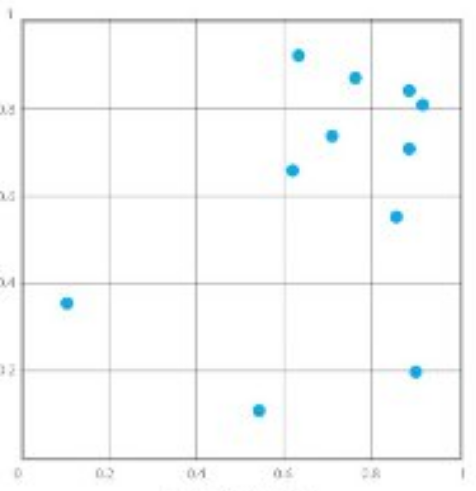

In [23]:
Image("media/random_search.png")

Why does a Random Search usually perform better than a GridSearch? In ideal conditions, if time/money were no issue, a Grid Search would always perform better (because it tries all of the options). However, because of time constraints, a Random Search can explore more diverse combinations of hyperparameters (and find those hyperparameters that matter the most) than a Grid Search given a specific amount of time.

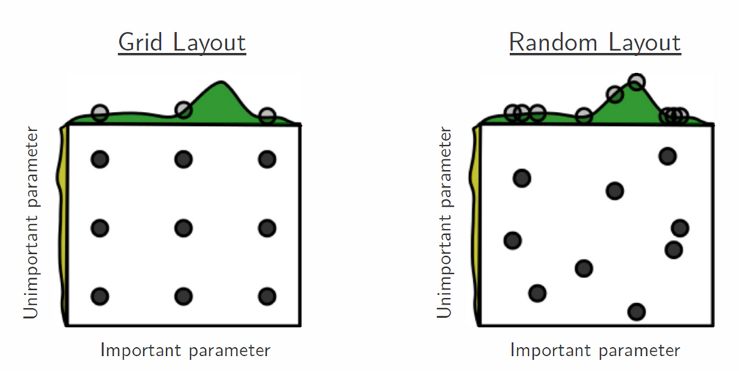

In [24]:
Image("media/grid_vs_random_search.png")

In [25]:
# Import the Random Seaarch class from sklearn
from sklearn.model_selection import RandomizedSearchCV
# Check its usage
RandomizedSearchCV?

To run a randomized search in scikit-learn, it is recommended to use statistical distributions instead of simple lists or ranges when defining the search space.

In [26]:
from scipy.stats import randint

random_search_parameter_space_dist = {
                   "max_depth": randint(1, 100),
                   "max_features": randint(1, len(independent_variables)),
                   "class_weight": ["balanced", None]
                  }

We set up the random search. We fix the random state `random_state=42` to ensure reproducibility (that is, the random search running in *your* computer should return the same results as the one running on *my* computer).

In [27]:
randomized_search = RandomizedSearchCV(
                        estimator, 
                        random_search_parameter_space_dist,
                        cv=5, n_iter=250,
                        random_state=42,
                        return_train_score=True
                        )

And we run it by fitting it to the data (same as with the GridSearchCV).

In [28]:
%%timeit -n 1 -r 1

randomized_search.fit(X_train, y_train)

8.43 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


The RandomizedSearch has the same attributes as the GridSearch.

In [29]:
randomized_search.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=30, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [30]:
randomized_search.best_score_

0.9384615384615385

### Model Selection

Now we have 2 possible models (the best one found with the grid search and the best one found by the Randomized Search). Which one should we choose?

Selecting a "final" model that we will use is not only a matter of selecting the model with the highest score. There are other aspects we must consider when evaluating one model versus another:

- Training Time: If one model takes 1 hour to train and another one takes 5 hours
- Prediction Time: If we are working on a real time predictive system, we cannot choose a model that takes seconds to perform a prediction!
- Interpretability: We may favor a less complex (or more interpretable) model due to regulations and/or our ability to explain it to clients


**Measuring predictive and computing performance**

We can evaluate the predictive performance of the models by using the test dataset we held at the beginning.

In [31]:
from sklearn.model_selection import cross_val_score, cross_validate

In [32]:
grid_results = cross_validate(grid_search.best_estimator_, X_test, y_test, scoring="roc_auc", 
                              return_train_score=True, cv=5)

In [33]:
grid_results

{'fit_time': array([0.00416994, 0.00222325, 0.00214577, 0.002249  , 0.00203919]),
 'score_time': array([0.00225377, 0.00208068, 0.00219202, 0.00177002, 0.00222778]),
 'test_score': array([0.96666667, 0.94444444, 0.94047619, 0.88888889, 0.89285714]),
 'train_score': array([0.9994898 , 1.        , 0.98452012, 1.        , 1.        ])}

We can turn these results into a dataframe and calculate their means. This way we can see how much time it takes to train the dataset, how much time it takes to predict (which matters for real time applications), and how does the model performs with the training and the test set.

In [34]:
pd.DataFrame(grid_results).mean()

fit_time       0.002565
score_time     0.002105
test_score     0.926667
train_score    0.996802
dtype: float64

We can do the same thing with the randomized search estimator.

In [35]:
random_results = cross_validate(randomized_search.best_estimator_,
                                X_test, y_test, scoring="roc_auc",
                                return_train_score=True, cv=5)
pd.DataFrame(random_results).mean()

fit_time       0.002110
score_time     0.002132
test_score     0.909206
train_score    1.000000
dtype: float64

Now that we know which model performs better on the train and test set, which model is the fastest to train, we can make a more inform decision.

### CheatSheet 

Though we often have several hyperparameters per estimator that we could tune, in practice most ot the performance variation can be attributed to just a few hyperparameters [[2](http://proceedings.mlr.press/v32/hutter14.html)]. To make your life easier, the table below suggests a couple of hyperparameters (using sklearn naming convention), for a select group of estimators, that usually have the greatest impact on the performance.

| Estimator        | Hyperparameter          | Notes  |
| ------------- |:-------------:| :-----|
| Logistic Regression      | penalty                  | Used to specify the norm used in the penalization. Can be '"l1", "l2", or "elasticnet"  |
| Logistic Regression      | C                            | Inverse of regularization strenght. Can go from close to zero (high variance) to large values (high bias) |
| SVM                                 | C                             | Inverse of regularization strenght. Can go from close to zero (high variance) to large values (high bias)|
| SVM                        | Kernel             | Type of kernel to use. Can be "linear", "poly", "rbf", or "sigmoid" |
| Tree Ensembles      | n_estimators |    Number of estimators to use. In practice up to hundreds of estimators are used  |
| Tree Ensembles             |  max_depth         |    Maximum depth of tree. Small values result in less complexity (1 often works well for Boosting) |
| KNN                                 | n_neighbors         |   Number of neighbors to use. Small values result in higher variace while larger ones in higher bias |
| KNN                                 |  weights                |   Weight function used in prediction. Can be "uniform" or "distance" |

Starting with the hyperparamters above is often a reasonable choice. 


### Recap

* Hyperparameters define the structure of our estimators
* Different from parameters, which are computed by the model
* Hyperparameter search to select best hyperparameters
 * Grid search
 * Random search
* Model selection

### Further readings

* http://proceedings.mlr.press/v32/hutter14.html
* https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)